In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D,Input,MaxPooling2D,Dropout,Conv2DTranspose,Activation,concatenate

In [57]:
def conv2d_block(input_tensor,n_filters,kernel_size=3):
  x = input_tensor
  for i in range(2):
    x = Conv2D(filters=n_filters,kernel_size=(kernel_size,kernel_size),padding="same")(x)
    x = Activation("relu")(x)
  return x

In [58]:
def encoder_block(inputs,n_filters,pool_size=(2,2),dropout=0.3):
  f = conv2d_block(inputs,n_filters)
  p = MaxPooling2D(pool_size=(2,2))(f)
  p = Dropout(dropout)(p)
  return f,p

In [59]:
def encoder(inputs):
  f1,p1 = encoder_block(inputs,n_filters=64,pool_size=(2,2),dropout=0.3)
  f2,p2 = encoder_block(p1,n_filters=128,pool_size=(2,2),dropout=0.3)
  f3,p3 = encoder_block(p2,n_filters=256,pool_size=(2,2),dropout=0.3)
  f4,p4 = encoder_block(p3,n_filters=512,pool_size=(2,2),dropout=0.3)

  return p4,(f1,f2,f3,f4)

In [60]:
def bottle_neck(inputs):
  bottleneck = conv2d_block(inputs,n_filters=1024)
  return bottleneck

In [61]:
def decoder_block(inputs,conv_output,n_filters=64,kernel_size=(3,3),strides=3,dropout=0.3):
  transpose = Conv2DTranspose(filters=n_filters,kernel_size=kernel_size,strides=strides,padding="same")(inputs)
  concat = concatenate([transpose,conv_output])
  concat = Dropout(dropout)(concat)
  concat = conv2d_block(concat,n_filters=n_filters,kernel_size=3)
  return concat

In [62]:
def decoder(inputs,convs,num_classes):
  f1,f2,f3,f4 = convs
  x = decoder_block(inputs,f4,n_filters=512,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  x = decoder_block(x,f3,n_filters=256,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  x = decoder_block(x,f2,n_filters=128,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  x = decoder_block(x,f1,n_filters=64,kernel_size=(3,3),strides=(2,2),dropout=0.3)

  output = Conv2D(num_classes,(1,1),activation="softmax")(x)
  return output

In [63]:
def UNnet():
  inputs = Input(shape=(128,128,3,))
  encoder_output,conv_layers = encoder(inputs)
  bottleneck = bottle_neck(encoder_output)
  final_output = decoder(bottleneck,conv_layers,3) #since our dataset contanins 3 classes
  model = tf.keras.Model(inputs=inputs,outputs=final_output)
  return model

In [64]:
my_model = UNnet()

In [65]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 128, 128, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 128, 128, 64) 0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 128, 128, 64) 36928       activation_31[0][0]              
______________________________________________________________________________________________

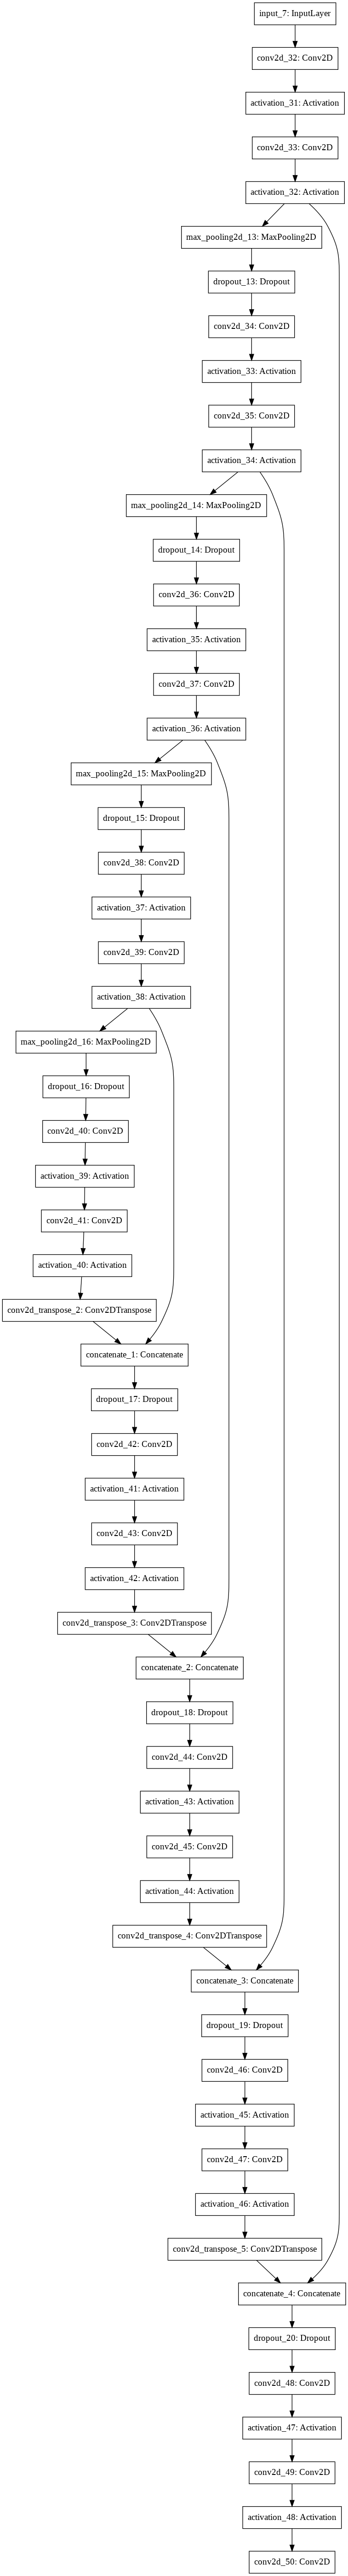

In [66]:
tf.keras.utils.plot_model(my_model)